In [1]:
#load libraries 
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
train_df = pd.read_csv('/Users/shichen/Dropbox/UCSC Extension/Object-oriented design/widsdatathon2023/train_data.csv', parse_dates = ['startdate'])
test_df = pd.read_csv('/Users/shichen/Dropbox/UCSC Extension/Object-oriented design/widsdatathon2023/train_data.csv', parse_dates = ['startdate'])

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375734 entries, 0 to 375733
Columns: 246 entries, index to wind-vwnd-925-2010-20
dtypes: datetime64[ns](1), float64(240), int64(4), object(1)
memory usage: 705.2+ MB


In [3]:
train_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,-27.68,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,-21.13,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,-10.72,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,0.33,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,9.83,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95


In [5]:
# check the data type of each column
train_df.dtypes

index                                          int64
lat                                          float64
lon                                          float64
startdate                             datetime64[ns]
contest-pevpr-sfc-gauss-14d__pevpr           float64
                                           ...      
wind-vwnd-925-2010-16                        float64
wind-vwnd-925-2010-17                        float64
wind-vwnd-925-2010-18                        float64
wind-vwnd-925-2010-19                        float64
wind-vwnd-925-2010-20                        float64
Length: 246, dtype: object

In [9]:
train_df['contest-prwtr-eatm-14d__prwtr'].describe()

count    375734.000000
mean         14.298038
std           8.142212
min           2.700000
25%           8.350000
50%          12.050000
75%          17.820000
max          52.660000
Name: contest-prwtr-eatm-14d__prwtr, dtype: float64

In [7]:
# Dropping index column and filling missing values in the training dataset using bfill method
# There are no missing values in test dataset
train_df.drop('index',axis=1,inplace=True)
test_df.drop('index',axis=1,inplace=True)
train_df.fillna(inplace=True, method='bfill')

In [8]:
# Creating new columns from the date column
train_df["day"] = train_df["startdate"].dt.day
train_df["month"] = train_df["startdate"].dt.month
test_df["day"] = test_df["startdate"].dt.day
test_df["month"] = test_df["startdate"].dt.month

In [9]:
# Dealing with location column and make new columns from it using One-Hot-Encoding.
# [Reference](https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved)

scale = 14
train_df.loc[:,'lat']=round(train_df.lat,scale)
train_df.loc[:,'lon']=round(train_df.lon,scale)

test_df.loc[:,'lat']=round(test_df.lat,scale)
test_df.loc[:,'lon']=round(test_df.lon,scale)

train_df['location'] = train_df.lat.astype(str) + ' , ' + train_df.lon.astype(str)
test_df['location'] = test_df.lat.astype(str) + ' , ' + test_df.lon.astype(str)

dummies = pd.get_dummies(train_df.location)
train_df = pd.concat([dummies, train_df], axis = 1)
dummies = pd.get_dummies(test_df.location)
test_df = pd.concat([dummies, test_df], axis = 1)

In [10]:
# Using lag features on elevation__elevation column
for i in range(1, 4):
    train_df['lag{}'.format(i)] = train_df['elevation__elevation'].shift(i)
    test_df['lag{}'.format(i)] = test_df['elevation__elevation'].shift(i)

In [11]:
# Dropping non-numeric columns after transfering them
target = 'contest-tmp2m-14d__tmp2m'

X_train = train_df.copy()
X_train.drop(['climateregions__climateregion', 'startdate', 'lat', 'lon', 'location'], axis=1, inplace=True)

y_train = X_train[target]

X_train.drop([target], axis=1, inplace=True)

X_test = test_df.copy()
X_test.drop(['climateregions__climateregion', 'startdate', 'lat', 'lon', 'location'], axis=1, inplace=True)


In [12]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
y_pred = model.predict(X_train)

In [14]:
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")


Mean Squared Error: 2.1686
R2 Score: 0.9777


In [17]:
from xgboost import plot_importance

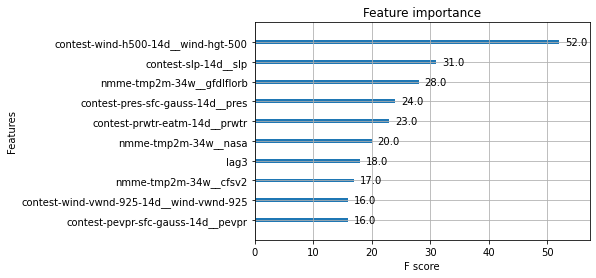

In [18]:
# Plot the feature importance with the top 10 features
ax = plot_importance(model, max_num_features=10, importance_type='weight')
plt.show()

In [19]:
# check the descriptive statistics of contest-wind-h500-14d__wind-hgt-500
train_df['contest-wind-h500-14d__wind-hgt-500'].describe()

count    375734.000000
mean       5728.370672
std         123.805703
min        5289.250000
25%        5644.070000
50%        5732.220000
75%        5827.680000
max        5958.200000
Name: contest-wind-h500-14d__wind-hgt-500, dtype: float64

In [ ]:
tr.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,-27.68,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,-21.13,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,-10.72,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,0.33,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,9.83,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95


In [ ]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375734 entries, 0 to 375733
Columns: 246 entries, index to wind-vwnd-925-2010-20
dtypes: datetime64[ns](1), float64(240), int64(4), object(1)
memory usage: 705.2+ MB


In [ ]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375734 entries, 0 to 375733
Columns: 246 entries, index to wind-vwnd-925-2010-20
dtypes: datetime64[ns](1), float64(240), int64(4), object(1)
memory usage: 705.2+ MB


In [ ]:
ts.isna().sum()

index                                 0
lat                                   0
lon                                   0
startdate                             0
contest-pevpr-sfc-gauss-14d__pevpr    0
                                     ..
wind-vwnd-925-2010-16                 0
wind-vwnd-925-2010-17                 0
wind-vwnd-925-2010-18                 0
wind-vwnd-925-2010-19                 0
wind-vwnd-925-2010-20                 0
Length: 246, dtype: int64